# Tutorial for spectrum_overload
- Jason Neal 
- September 2016

Spectrum is a module based around a class called Spectrum. It allows you easily perform operations between spectra by overloading the operators +-*/.

In my reseach involving NIR spectroscopy of exoplanets I need to perform different operations on or between spectra. For example to correct for the telluric absoption lines of earth it is nessary to divide the observations by either a telluric observation or model. I was tired of carrying around multiple objects the dispersion axis and the flux values for each observation and each model. 
When performing operations between spectra it is nessesary to interpolate either one or both spectra to the same dispersion result to perform the operation at the same wavelength values. 

This led me to create the Spectrum class so that I could easily subtract or divide two spectra from each other.

Below is some basic instuction on how to use it and a telluric correction example


In [1]:
from __future__ import division, print_function
from spectrum_overload import Spectrum
from astropy.io import fits
import copy
import numpy as np
import matplotlib.pyplot as plt


You create a spectrum object by passing in the flux and the dispersion values. As positional arguments flux is first. If your dispersion axis has been wavelenght calibrated (its a wavelength rather than pixel positions) then you need to also pass in calibrated=True keyword.

In [2]:
x = np.arange(2000, 2050)
y = np.random.rand(len(x))
spec_uncalibrated = Spectrum(y, x)
spec_calibrated = Spectrum(flux=y, xaxis=x, calibrated=True)


If you need access to the dispersion axis or flux you can do it by the flux and xaxis attributes. 

In [3]:
wavelength = spec_uncalibrated.xaxis 
I = spec_uncalibrated.flux

Spectrum has a wave_select metod which allows you to select a section of you spectra between an lower and upper dispersion coordinate(pixel/wavelenght).

In [4]:
#spec_calibrated.wav_select(lower, upper)
spec_calibrated.wav_select(2030, 2070)


## Overloaded Operators:  
Warning this section is still to implement in the class!

You can preform basic operations with the spectrum objects.

The two specta need to be of the same calibration status.
If the spectra are calibtrated and their dispersion values are not the same then the second spectrum will be interpolated to the wavelenght values of the first. 

(At this stage I discoverd another spectum project which talked about overloading operators like this but never actually done it.)

In [5]:
spec1 = Spectrum(y, x, calibrated=True)
spec2 = copy.copy(spec1)   # Duplicate to easily see result.  mainly spec1-spec2=0, spec1/spec2=1

# this is still to operate.
add = spec1 + spec2
subtract = spec1 - spec2
multiply = spec1 * spec2
divide = spec1 / spec2

print("add", add.flux)
print("subtract", subtract.flux)
print("multiply", multiply.flux)
print("divide", divide.flux)

add [1.70203291 1.20704382 1.16797748 0.62837019 1.40323123 0.84373963
 1.3903804  0.06070615 1.77941362 1.69980907 1.54330885 1.83766468
 1.48231499 1.80771465 1.40542936 0.35509179 0.48959352 0.38532826
 1.88849798 0.37656281 1.8370013  0.40189669 1.96548297 0.54524153
 1.16443362 1.24792465 0.56880421 1.42732791 1.68579551 0.34775402
 1.12921057 1.28120493 0.10417879 1.86802101 0.83211694 1.98394316
 0.5018036  0.47683853 0.68797368 1.70136996 1.80879392 0.94254361
 0.98815783 1.02281889 1.95058898 1.91379936 0.99529278 1.81349203
 0.0552135  1.4813729 ]
subtract [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
multiply [7.24229010e-01 3.64238695e-01 3.41042847e-01 9.87122733e-02
 4.92264473e-01 1.77974141e-01 4.83289411e-01 9.21309106e-04
 7.91578208e-01 7.22337717e-01 5.95450552e-01 8.44252868e-01
 5.49314429e-01 8.16958064e-01 4.93807924e-01 3.15225441e-02
 5.99254539e-02 3.71

# Practical Example - Telluric Correction
We want to divide an observation by a model of the telluric absorbtion to correct for Earths absoption

In [6]:
# A function to read header and data from tapas ipac file.
def load_telluric(filename):
    """ Returns telluric data and header
    if just want the data then call as load_telluric()[0]
    or data, __ = load_telluric() 

    likewise just the header as hdr = load_telluric()[1]"""
    ext = filename.split(".")[-1]
    if ext == "ipac":
        tell_hdr = fits.Header()
        with open(filename) as f:
            col1 = []
            col2 = []
            for line in f:
                #firstchar = line[0]
                #print("first char =", firstchar)
                if line.startswith("\\"):
                    # Get the Tapas Header
                    line = line[1:] # remove the leading \
                    line = line.strip()
                    items = line.split("=")

                    tell_hdr[items[0]] = items[1] # Add to header

                elif line.startswith("|"):
                    # Obtian wavelength scale from piped lines
                    if "in air" in line:
                        tell_hdr["WAVSCALE"] = "air"
                    elif "nm|" in line:
                        tell_hdr["WAVSCALE"] = "vacuum"
                    # Need extra condition to deal with wavenumber
                else:
                    line = line.strip()
                    val1, val2 = line.split()
                    col1.append(float(val1))
                    col2.append(float(val2))

    elif ext == "fits":
        i_tell = fits.getdata(filename, 1)
        tell_hdr = fits.getheader(filename, 1)
        # TODO ... Need to get wavelenght scale (air/wavelenght) from fits file somehow... 
        col1 = i_tell["wavelength"]
        col2 = i_tell["transmittance"]

    else:
        print(" Could not load file", filename," with extention", ext)
        return None
        
        # put in ascending order
    if col1[-1]-col1[0] < 0:  # wl is backwards
            col1 = col1[::-1]
            col2 = col2[::-1]                
    tell_data = np.array([col1, col2], dtype="float64")

    return tell_data, tell_hdr 

In [7]:
## Load in the spectra 
# Using already wavelength calibrated slectrum
obsname = "../spectrum_overload/data/spec_wavecal.fits"
tellname = "../spectrum_overload/data/telluric_data.ipac"

# Load in the data
obs_data = fits.getdata(obsname)
obs_hdr = fits.getheader(obsname)
telluric_data, telluric_header = load_telluric(tellname)

## Put data into Spectrum object
# Can check for column names using print(obs.columns)
# "Wavelength" and "Extracted_DRACS" are the columns of the fits table
observation = Spectrum(obs_data["Extracted_DRACS"], obs_data["Wavelength"], calibrated=True, header=obs_hdr)

telluric = Spectrum(telluric_data[1], telluric_data[0], calibrated=True, header=telluric_header)


Now the telluric model wavelength spans a much longer wavelength than we have observed.
It is a good idea to shorten it to the values we have to save memory.

In [8]:
# Shorten telluric spectra to just around our observation (1 nm either side)
print("Before ", len(telluric))
telluric.wav_select(min(observation.xaxis)-1, max(observation.xaxis)+1)  
print("After  ", len(telluric))

Before  13975
After   3218


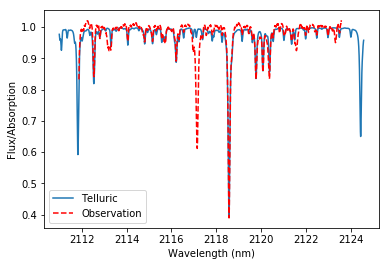

In [9]:
# Plot the two Spectrum to see what we have
plt.figure()
plt.plot(telluric.xaxis, telluric.flux, label="Telluric")
plt.plot(observation.xaxis, observation.flux, "r--", label="Observation")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux/Absorption")
#plt.xlim([np.min(observation.xaxis), np.max(observation.xaxis)])   # Veiw this detector only
plt.legend(loc=0)
plt.show()


There can a difference in airmass between the observation and the model which affects the line depth.
We can scale the tellruic model by the ratio of airmas to correct the line depths

In [10]:
B = observation.header["HIERARCH ESO TEL AIRM END"] / float(telluric.header["airmass"])  # Should probably average airmass of observation (Not just End as used here)
print("Airmass Ratio = {}".format(B))
scaled_telluric = telluric ** B

Airmass Ratio = 0.9588151722519749


Now we want to correct for the atmospheric absorption be dividing the observation by the telluric model.


In [11]:
# Warning! When I attempted a division before applying the telluric.wav_select() above I obtained a MemoryError in the interpolation
# This needs to be looked into (it takes a while to run atm)

Corrected = observation / scaled_telluric

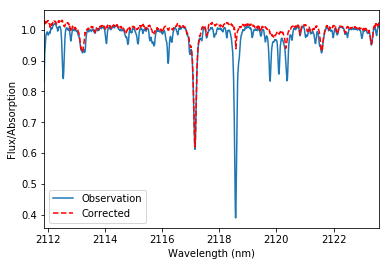

In [12]:
# Plot Result
plt.plot(observation.xaxis, observation.flux, label="Observation")
plt.plot(Corrected.xaxis, Corrected.flux, "r--", label="Corrected")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Flux/Absorption")
plt.xlim([np.min(observation.xaxis), np.max(observation.xaxis)])   # Veiw this detector only
plt.legend(loc=0)
plt.show()
